In [69]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2
%aimport bs_eda

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import bs_lib.bs_eda as beda
import bs_lib.bs_preprocess_lib as bsp
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

## Liste des modifications

1. Pour les variables `mileage` et `price`, convertir les int64 en float64
1. Supprimer les entrées redondantes
1. `price`:
    * Vérifier les valeurs anormales *Z-score*
    * Log pour normaliser la distribution
1. `year`:
    * Supprimer les années excentriques
    * vérifier les voitures avant 2000
1. `mileage`:
    * Traiter la précense d'anomalies dans les valeurs hautes
    * idem valeurs basses
1. `mpg`:
    * Vérifier la validité des valeurs extrêmes, trop basses et trop hautes.
    * Créer une échelle discrète de rendement: bas, moyen, haut
1. `engine_size`
    * Corriger ou supprimer les valeurs 0
    * traiter les valeurs de 6
    * Créer une échelle discrète de taille de moteur: small, large
    * Utiliser un OrdinalEncoder?
1. `tax`
    * Les données apparaissent difficilement fiables, la feature pourrait être supprimée.
1. Variable discrète
    * Encoder les features. LabelEncoder et/ou OneHotEncoder?
1. `transmission`
    * Supprimer les entrées pour lesquelles le mode de transmission est `Other`
1. `fuel_type`
    * Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
1. `model`
    * LabelEncoder
    * Suppression du `model` si trop forte colinéarité  entre `brand`et `model`

In [2]:
df = pd.read_csv('dataset/train_set.csv', index_col=0)
df.shape

(74387, 10)

In [3]:
# Supprimer les entrées redondantes
df.drop_duplicates(inplace = True)
df.shape

(73478, 10)

In [4]:
# Pour les variables `mileage` et `price`, convertir les int64 en float64
df['price'] = df['price'].astype(float)
df['mileage'] = df['mileage'].astype(float)

In [13]:
# Vérifier les valeurs anormales *Z-score*
# Log pour normaliser la distribution
columns = beda.get_numerical_columns(df)
thresh = 3
# mask of all rows whose value > thresh
def x_or_nan(x):
    if np.abs(zscore(x, nan_policy = 'omit')) > thresh:
        return np.nan
    else:
        return x

outliers = df[columns].apply(lambda x: np.abs(zscore(x, nan_policy = 'omit')) > thresh)#.any(axis=1)
# replace value from outliers by nan
df[outliers] = np.nan
#df_ = df[columns].where(~outliers, other=np.nan)
#df.drop(df[columns].index[outliers], inplace = True)
#df = pd.concat([df_,df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73478 entries, 3053 to 13349
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         73478 non-null  object 
 1   year          72163 non-null  float64
 2   price         71371 non-null  float64
 3   transmission  73478 non-null  object 
 4   mileage       71369 non-null  float64
 5   fuel_type     73478 non-null  object 
 6   tax           72815 non-null  float64
 7   mpg           72966 non-null  float64
 8   engine_size   72765 non-null  float64
 9   brand         73478 non-null  object 
dtypes: float64(6), object(4)
memory usage: 6.2+ MB


In [14]:
# Year as category
#bins=np.arange(df['year'].min()-1,df['year'].max()+2)
#print(bins)
#df['year_category']=pd.cut(df['year'],bins=bins)

In [15]:
# Créer une échelle discrète de rendement: bas, moyen, haut
#def fuel_economy(mpg):
#    average = (36,47)
#    if mpg<=average[0]: 
#        result = "Low"
#    if (mpg>average[0] and mpg<average[1]): 
#        result = "Medium"
#    if mpg>=average[1]: 
#        result = "High"
#    return result

#df["fuel_economy"]=df.apply(lambda x: fuel_economy(x["mpg"]),axis=1)

#sns.countplot(data=df,x="fuel_economy")

In [16]:
# Complete engine_size == 0
#def replace_by_similar(row, from_data, where_feature, has_cdt_value, using_features):
#    x = row.copy()
#    if row[where_feature]==has_cdt_value:
#        result = beda.get_similar_row(to_this_row=row, in_data=from_data, based_on_cols=cols, show=False)
#        if not result.isnull().values.any():
#            x[where_feature] = round(result[where_feature].quantile(q=0.75),2)
#    return x

#feature='engine_size'
#search_in_df = df[df[feature]>0]
#cols = ['model','transmission', 'fuel_type', 'brand']
#df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
#                                           has_cdt_value=0, using_features=cols), axis=1)

In [17]:
# Créer une échelle discrète de taille de moteur: small, high
#def get_engine_class(engine_size):
#    if engine_size<2.:
#        result = 'small'
#    else:
#        result = 'large'
#    return result
#
#df["engine_class"]=df.apply(lambda x: get_engine_class(x["engine_size"]),axis=1)
#sns.countplot(data=df,x="engine_class")

In [18]:
# Complete tax == 0
#feature='tax'
#search_in_df = df[df[feature]>0]
#cols = ['mpg','engine_size']
#df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
#                                           has_cdt_value=0, using_features=cols), axis=1)

In [19]:
# suppression de `tax` ou
# Créer une échelle discrète de forfait de taxe: small, high
#max_tax = df['tax'].max()
#bins = [-1,100,125,175,225,250,275,max_tax+1]
#labels = []
#for i in range(len(bins)-1):
#    start = bins[i]
#    end = bins[i+1]
#    if i==0:
#        label = f"<{end}]"
#    else:
#        label = f"]{start},{end}]" 
#    labels.append(label)

#df['tax_package']=pd.cut(df['tax'],
#                         bins=bins,
#                         labels=labels)
#figure = sns.countplot(data=df,x="tax_package")
#figure.set_xticklabels(figure.get_xticklabels(),rotation=45, horizontalalignment='right')
#None

In [20]:
# `transmission`
# Supprimer les entrées pour lesquelles le mode de transmission est `Other`

In [21]:
df = df[df['transmission']!='Other']

In [22]:
# `fuel_type`
# Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
df = df[(df['fuel_type']!='Other')]
df = df[(df['fuel_type']!='Electric')]

In [23]:
# models supprimés par suppression des outliers
unprocessed_data = pd.read_csv('dataset/train_set.csv', index_col=0)
results = unprocessed_data[~unprocessed_data['model'].apply(tuple,1).isin(df['model'].apply(tuple,1))]['model']
print(results.unique())

[]


In [24]:
df.describe(include='all')

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,brand
count,73278,71965.000000,71174.000000,73278,71172.000000,73278,72616.000000,72805.000000,72568.000000,73278
unique,194,NaN,NaN,3,NaN,3,NaN,NaN,NaN,9
top,Fiesta,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,ford
freq,4886,NaN,NaN,41788,NaN,40654,NaN,NaN,NaN,13376
mean,NaN,2017.228417,15738.160368,NaN,21070.257784,NaN,118.058141,54.442227,1.651094,NaN
std,NaN,1.736223,7520.660136,NaN,17012.994655,NaN,58.586200,11.248507,0.505853,NaN
min,NaN,2012.000000,450.000000,NaN,1.000000,NaN,0.000000,20.800000,1.000000,NaN
25%,NaN,2016.000000,9995.000000,NaN,7327.750000,NaN,125.000000,46.300000,1.200000,NaN
50%,NaN,2017.000000,13999.000000,NaN,16899.000000,NaN,145.000000,54.300000,1.600000,NaN
75%,NaN,2019.000000,19995.000000,NaN,30996.750000,NaN,145.000000,62.800000,2.000000,NaN


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73278 entries, 3053 to 13349
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         73278 non-null  object 
 1   year          71965 non-null  float64
 2   price         71174 non-null  float64
 3   transmission  73278 non-null  object 
 4   mileage       71172 non-null  float64
 5   fuel_type     73278 non-null  object 
 6   tax           72616 non-null  float64
 7   mpg           72805 non-null  float64
 8   engine_size   72568 non-null  float64
 9   brand         73278 non-null  object 
dtypes: float64(6), object(4)
memory usage: 6.1+ MB


In [26]:
imputer = KNNImputer(weights='distance')
columns = beda.get_numerical_columns(df)
df[columns] = pd.DataFrame(imputer.fit_transform(df[columns]),columns=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73278 entries, 3053 to 13349
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         73278 non-null  object 
 1   year          73278 non-null  float64
 2   price         73278 non-null  float64
 3   transmission  73278 non-null  object 
 4   mileage       73278 non-null  float64
 5   fuel_type     73278 non-null  object 
 6   tax           73278 non-null  float64
 7   mpg           73278 non-null  float64
 8   engine_size   73278 non-null  float64
 9   brand         73278 non-null  object 
dtypes: float64(6), object(4)
memory usage: 6.1+ MB


### Nombre de cluster pour `engine_size`

No handles with labels found to put in legend.


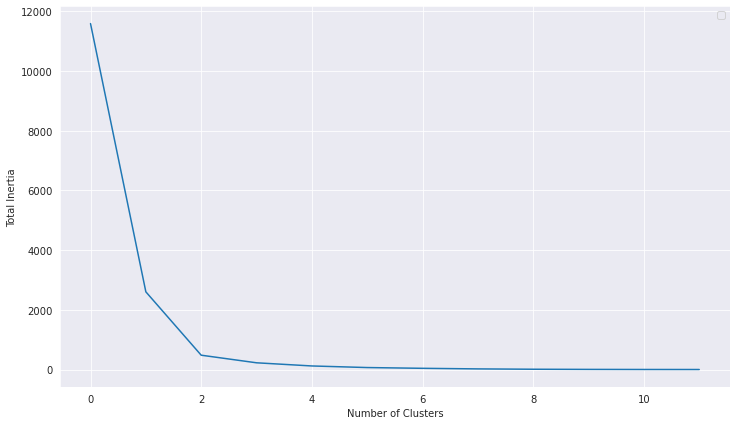

In [27]:
bsp.show_elbow(df['engine_size'].values.reshape(-1, 1),max_iter=12)

## Generate CSV

In [67]:
directory = 'dataset/'
df.to_csv(join(directory,'train_set_light_preprocessed.csv'))